In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pickle import dump

In [2]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.layers import Dense, LSTM, Embedding, RepeatVector, TimeDistributed
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.models import load_model, Sequential

In [3]:
## Drop all duplicate rows 

df = pd.read_csv(r'data\deu.txt',sep = '\t')
df.drop_duplicates(subset='1', keep=False, inplace=True)
data = np.array(df[:12000])

## Preprocessing - punctuations and lower case 

In [4]:
# Remove Punctuations and Lower Case

def processing(data):
    clean = []
    for words in data:
        # Remove Punctuation
        cleaned_word = "".join(letter for letter in words if letter not in ("?", ".", ";", ":", "!"))
        clean.append(cleaned_word)
    # Lower Case
    clean = [word.lower() for word in clean]
    return clean

In [5]:
data[:,0] = processing(data[:,0])
data[:,1]= processing(data[:,1])

## Tokenizer and max length of i/p and o/p 

In [6]:
# function to build a tokenizer

def tokenization(lines):
    tokenizer = Tokenizer()
    tokenizer.fit_on_texts(lines)
    return tokenizer

In [7]:
# sentence length

def vocab_length(lines):
    lengths = [len(line.split()) for line in lines]
    return lengths

In [8]:
eng_vocabs = vocab_length(data[:, 0])
ger_vocabs = vocab_length(data[:, 1])

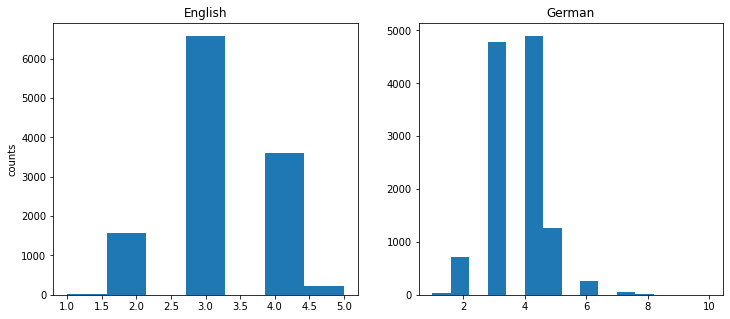

In [9]:
## Distribution of Lengths of English and German Vocabularies

plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.hist(eng_vocabs, bins=7)
plt.ylabel('counts')
plt.title('English')

plt.subplot(1,2,2)
plt.hist(ger_vocabs, bins=15)
plt.title('German')
plt.show()

In [10]:
# English tokenizer

eng_tokenizer = tokenization(data[:, 0])
eng_vocab_size = len(eng_tokenizer.word_index) + 1
eng_length = max(eng_vocabs)

print('English Vocabulary Size: %d' % eng_vocab_size)
print('English Max Length: %d' % (eng_length))

English Vocabulary Size: 3390
English Max Length: 5


In [11]:
# German tokenizer

ger_tokenizer = tokenization(data[:, 1])
ger_vocab_size = len(ger_tokenizer.word_index) + 1
ger_length = max(ger_vocabs)

print('German Vocabulary Size: ', ger_vocab_size)
print('German Max Length: ', ger_length)

German Vocabulary Size:  4419
German Max Length:  10


## Integer Encoding to input 

In [12]:
# Integer encoding to input sentences and pad sequences to max length

def encode_sequences(tokenizer, length, lines):
    seq = tokenizer.texts_to_sequences(lines)
    seq = pad_sequences(seq, maxlen=length, padding='post')
    return seq

## One Hot Encoding to output 

In [13]:
# one hot encode for output sentences

def encode_output(sequences, vocab_size):
    ylist = list()
    for sequence in sequences:
        encoded = to_categorical(sequence, num_classes=vocab_size)
        ylist.append(encoded)
    y = np.array(ylist)
    y = y.reshape(sequences.shape[0], sequences.shape[1], vocab_size)
    return y

In [14]:
from sklearn.model_selection import train_test_split
train, test = train_test_split(data, test_size=0.2, random_state = 42)

In [15]:
#  Training data
x_train = encode_sequences(eng_tokenizer, eng_length, train[:, 0])
y_train = encode_sequences(ger_tokenizer, ger_length, train[:, 1])
y_train = encode_output(y_train, ger_vocab_size)


In [17]:
y_train[0]

array([[0., 0., 1., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [1., 0., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.]], dtype=float32)

In [18]:
# Test data
x_test = encode_sequences(eng_tokenizer, eng_length, test[:, 0])
y_test = encode_sequences(ger_tokenizer, ger_length, test[:, 1])
y_test = encode_output(y_test, ger_vocab_size)

In [19]:
print("Train input shape : ", x_train.shape, "\nTrain output shape : ",y_train.shape)
print("Test input shape : ",x_test.shape, "\nTest output shape : ",y_test.shape)

Train input shape :  (9600, 5) 
Train output shape :  (9600, 10, 4419)
Test input shape :  (2400, 5) 
Test output shape :  (2400, 10, 4419)


In [20]:
# Seq2Seq Model
def define_model(src_vocab, tar_vocab, src_timesteps, tar_timesteps, n_units):
      model = Sequential()
      model.add(Embedding(src_vocab, n_units, input_length=src_timesteps, mask_zero=True))
      model.add(LSTM(n_units))
      model.add(RepeatVector(tar_timesteps))
      model.add(LSTM(n_units, return_sequences=True))
      model.add(TimeDistributed(Dense(tar_vocab, activation='softmax')))
      return model

In [21]:
model = define_model(eng_vocab_size, ger_vocab_size, eng_length, ger_length, 250)
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [22]:
#filename = 'model1.h5'
#checkpoint = ModelCheckpoint(filename, monitor='val_loss', verbose=1, save_best_only=True, mode='min')callbacks=[checkpoint],
model.fit(trainX, trainY, epochs=2, batch_size=68, validation_data=(testX, testY), verbose=1)

Train on 9600 samples, validate on 2400 samples
Epoch 1/2
9600/9600 [==============================] - 60s 6ms/sample - loss: 3.2359 - accuracy: 0.6409 - val_loss: 2.3887 - val_accuracy: 0.6610
Epoch 2/2
9600/9600 [==============================] - 51s 5ms/sample - loss: 2.2599 - accuracy: 0.6653 - val_loss: 2.2299 - val_accuracy: 0.6768


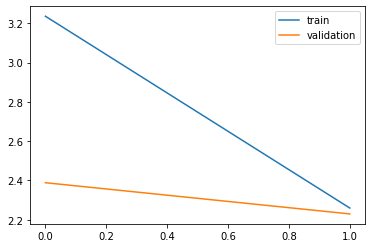

In [24]:
plt.plot(model.history.history['loss'])
plt.plot(model.history.history['val_loss'])
plt.legend(['train','validation'])
plt.show()

In [25]:
loss = model.history.history['loss']
accuracy = model.history.history['loss']
val_loss = model.history.history['val_loss']
val_accuracy = model.history.history['val_accuracy']

In [ ]:
dump(loss, open('data/loss.pkl', 'wb'))
dump(loss, open('data/accuracy.pkl', 'wb'))
dump(loss, open('data/val_loss.pkl', 'wb'))
dump(loss, open('data/val_accuracy.pkl', 'wb'))

In [20]:
# Model
model_file = 'data/26th program/model_colab_gpu.h5'
model = load_model(model_file, compile=False)

In [30]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 5, 250)            847500    
_________________________________________________________________
lstm (LSTM)                  (None, 250)               501000    
_________________________________________________________________
repeat_vector (RepeatVector) (None, 10, 250)           0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 10, 250)           501000    
_________________________________________________________________
time_distributed (TimeDistri (None, 10, 4419)          1109169   
Total params: 2,958,669
Trainable params: 2,958,669
Non-trainable params: 0
_________________________________________________________________


## Input English Text to array Encoding 

In [21]:
def input_to_array(word):
    word_list = word.split()

    word_list = [word.lower() for word in word_list]
    punct_remove = []

    for txt in word_list:
        word_input = "".join(u for u in txt if u not in ("?", ".", ";", ":", "!"))
        punct_remove.append(word_input)
    
    output_array = np.zeros(5)
    for i in range(len(punct_remove)):
        for key, value in eng_tokenizer.word_index.items():
            if key == punct_remove[i]:
                np.put(output_array, i, value)
            else:
                pass
    output_array = output_array.astype(int)
    output_array = output_array.reshape(1, 5)
    
    return output_array

## Output array to german text Decoding 

In [22]:
def process_output(pred_value, tokenizer):
    #pred_value = model.predict_classes(input_array)
    
    pred_texts = []
    vals = []
    for i in pred_value:
        for word, index in tokenizer.word_index.items():
            if index == i:
                worrdd = word
                vals.append(worrdd)

    output = ' '.join(vals)
    pred_texts.append(output)
    return pred_texts


## BLEU Score  

In [23]:
pred_test = model.predict_classes(x_test)

In [24]:
pred_german = []
for i in range(len(pred_test)):
    process = process_output(pred_test[i], ger_tokenizer)
    pred_german.append(process)

In [25]:
pred_german_texts = np.array(pred_german).reshape(2400,)

In [26]:
actual_predicted = pd.DataFrame({'actual':test[:,1],'predicted':pred_german_texts})

In [ ]:
actual_predicted.head()

In [28]:
actual_predicted['predicted'] = actual_predicted['predicted'].astype(str)

In [29]:
## Sample out values with equal length

def count_col(data,column):
    final_counts = []
    for i in range(len(data[column])):
        count = len(data[column][i].split())
        final_counts.append(count)
    return final_counts

In [30]:
actual_predicted['act_counts'] = count_col(actual_predicted,'actual')
actual_predicted['pred_counts'] = count_col(actual_predicted,'predicted')
equal_lengths = actual_predicted[actual_predicted['act_counts']==actual_predicted['pred_counts']].index.tolist()

In [31]:
## DATAFRAME OF Equal length actual and predicted values

df_bleu = actual_predicted.loc[equal_lengths]

In [ ]:
import nltk
from nltk.translate.bleu_score import corpus_bleu

In [ ]:
corpus_bleu(df_bleu['actual'][0:10],df_bleu['predicted'][0:10],weights=(1,0,0,0))

In [ ]:
corpus_bleu(df_bleu['actual'][0:10],df_bleu['predicted'][0:10],weights=(0.5,0.5,0,0))

In [ ]:
corpus_bleu(df_bleu['actual'],df_bleu['predicted'],weights=(0.3,0.3,0.3,0))

## Final Check 

In [36]:
flag = True

while(flag == True):
    input_english = input('Enter a text in English : ')
    if( input_english != '123'):
        input_array1 = input_to_array(input_english)
        decode_sequence = process_output(input_array1, ger_tokenizer)
        print("Output German : ", decode_sequence)
    else:
        flag = False

Enter a text in English : Hello
Output French :  tom
Enter a text in English : kutta
Output French :  tom
Enter a text in English : 123
